<a href="https://colab.research.google.com/github/eohta/udemy-numpyro-basic/blob/main/04_babies/03_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Package

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(4)

In [3]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [8, 6]

## Load & Check Data

In [4]:
data = pd.DataFrame({
    
    'weeks':[36, 38, 39, 41, 37, 38, 40, 40, 38, 41, 38, 38, 40, 40, 36, 39, 40,
       35, 39, 38, 37, 43, 39, 39, 40, 40, 37, 38, 39, 38, 40, 40, 42, 37,
       41, 38, 37, 39, 40, 40, 38, 41, 38, 37, 39, 39, 43, 38, 38, 38],
    
    'weight':[2980, 2707, 3049, 3429, 2500, 2845, 3071, 3435, 3058, 3123, 3215,
       2902, 3015, 2983, 2727, 3121, 3114, 2511, 3327, 2864, 2749, 3621,
       2860, 3074, 3234, 3083, 2797, 3025, 3129, 2990, 3035, 2990, 3513,
       2687, 3380, 2863, 2715, 3012, 3083, 2938, 2837, 3455, 3175, 2646,
       2889, 2975, 3474, 3052, 3167, 2762],
    
    'gender':[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1]
})

In [ ]:
data.head(10)

## Preprocess & Scale Data

In [5]:
x = data['weeks'].values
y = data['weight'].values

gender = data['gender'].values

In [ ]:
x_mu = np.mean(x)
x_sd = np.std(x)

x_scaled = (x - x_mu) / x_sd

y_mu = np.mean(y)
y_sd = np.std(y)

y_scaled = (y - y_mu) / y_sd

## Define Model & Inference

In [7]:
def model(x_scaled=None, y_scaled=None, gender=None, num_data=0):
    
    a = numpyro.sample('a', dist.Normal(0, 10))
    b = numpyro.sample('b', dist.Normal(0, 10), sample_shape=(2,))
    
    mu = a * x_scaled + b[gender]
    
    sd = numpyro.sample('sd', dist.HalfCauchy(5))
    
    with numpyro.plate('data', num_data):
        
        numpyro.sample('obs', dist.Normal(mu, sd), obs=y_scaled)
        
    b_diff = numpyro.deterministic('b_diff', b[1] - b[0])

In [8]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup=500, num_samples=3000, num_chains=4)

mcmc.run(jax.random.PRNGKey(0), x_scaled=x_scaled, y_scaled=y_scaled, gender=gender, num_data=len(y_scaled))
mcmc_samples=mcmc.get_samples()

idata = az.from_numpyro(mcmc)

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

  0%|          | 0/3500 [00:00<?, ?it/s]

In [9]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

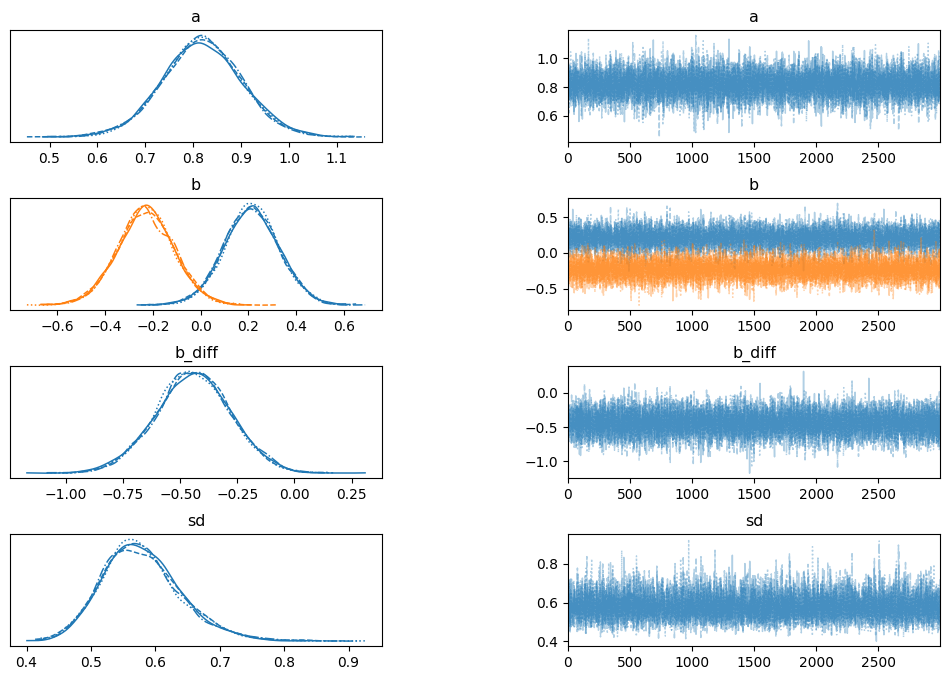

In [10]:
az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.818,0.084,0.667,0.983,0.001,0.001,13454.0,8447.0,1.0
b[0],0.213,0.116,0.002,0.437,0.001,0.001,12672.0,8289.0,1.0
b[1],-0.230,0.119,-0.453,-0.003,0.001,0.001,13032.0,8864.0,1.0
b_diff,-0.443,0.164,-0.756,-0.136,0.001,0.001,12731.0,8561.0,1.0
sd,0.579,0.062,0.470,0.700,0.001,0.001,12155.0,8705.0,1.0


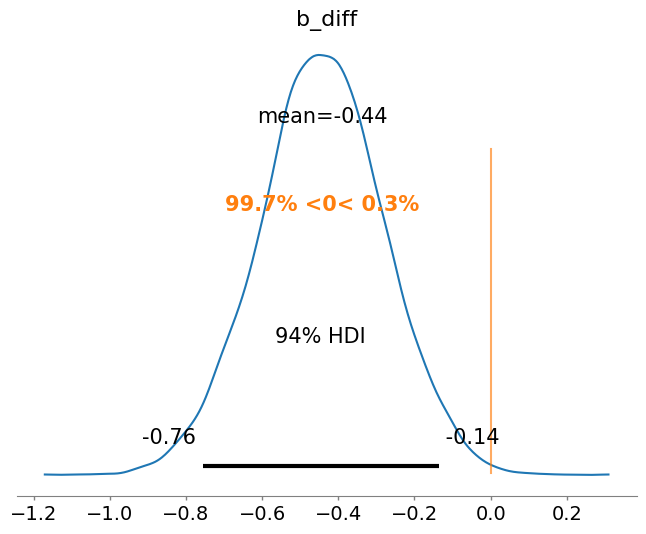

In [12]:
az.plot_posterior(idata, var_names=['b_diff'], ref_val=0);

## Information Criteria

In [13]:
az.waic(idata)

Computed from 12000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -44.70     3.82
p_waic        3.33        -

In [14]:
az.loo(idata)

Computed from 12000 posterior samples and 50 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -44.73     3.83
p_loo        3.36        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       50  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Compare Models

In [15]:
idata_imported = az.from_netcdf('idata.nc')

In [16]:
idata_dict = {'Slope is same':idata, 'Slope is different':idata_imported}

In [17]:
df_waic = az.compare(idata_dict, ic='waic', scale='deviance')
df_waic

/home/cristian/anaconda3/envs/numpyro_cpu_env/lib/python3.10/site-packages/arviz/stats/stats.py:1667: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
Slope is same,0,89.408323,3.332681,0.000000,0.6802,7.643139,0.0000,False,deviance
Slope is different,1,89.949425,4.153724,0.541102,0.3198,6.934175,2.4494,True,deviance


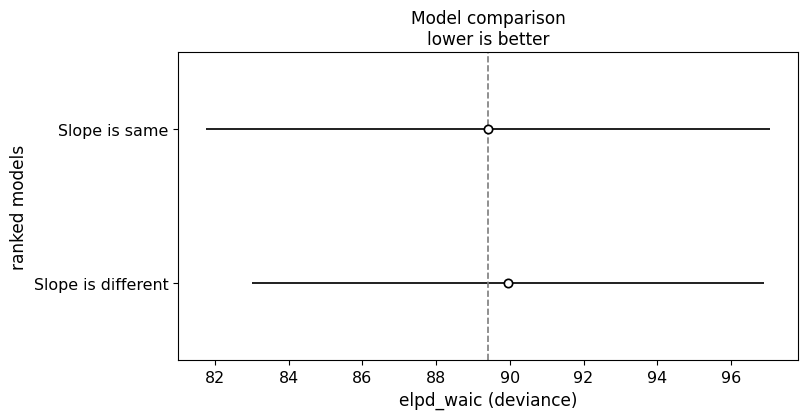

In [18]:
az.plot_compare(df_waic, figsize=(8, 4));

In [19]:
df_loo = az.compare(idata_dict, ic='loo', scale='deviance')
df_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Slope is same,0,89.462070,3.359554,0.00000,0.714551,7.654395,0.000000,False,deviance
Slope is different,1,90.116301,4.237162,0.65423,0.285449,6.951879,2.471235,False,deviance


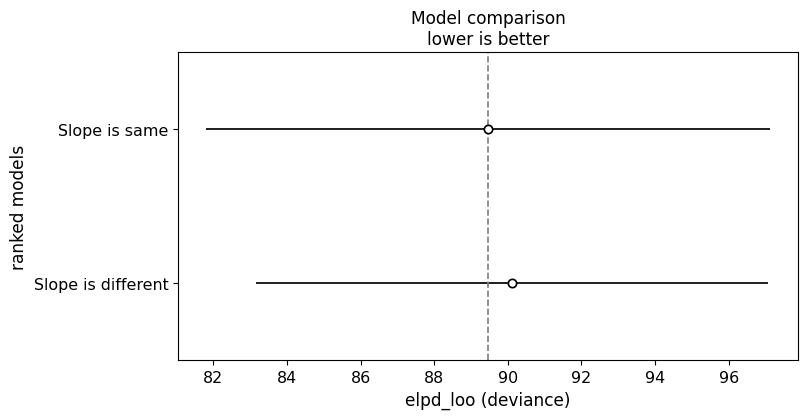

In [20]:
az.plot_compare(df_loo, figsize=(8, 4));

## Posterior Predictive Check

In [21]:
predictive = numpyro.infer.Predictive(model, mcmc_samples)

In [22]:
x_new = np.arange(35, 44)
x_scaled_new = (x_new - x_mu) / x_sd

In [23]:
# Case : Baby Boy
gender_new = np.zeros_like(x_new, dtype=int)

In [24]:
ppc_samples = predictive(jax.random.PRNGKey(1), x_scaled=x_scaled_new, gender=gender_new, num_data=len(x_scaled_new))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [25]:
obs_pred = idata_ppc.posterior_predictive['obs']
obs_mean = obs_pred.mean(axis=0).mean(axis=0)

In [26]:
obs_pred.shape

(4, 3000, 9)

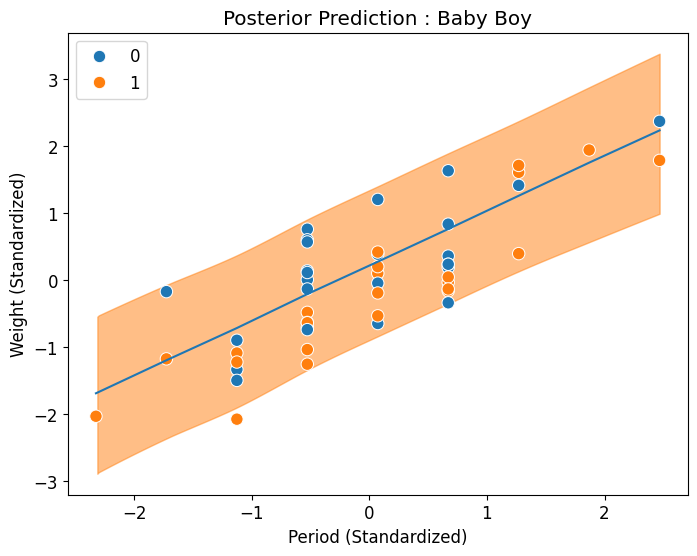

In [27]:
# 事後予測分布の表示
az.plot_hdi(x_scaled_new, obs_pred)
plt.plot(x_scaled_new, obs_mean)

# 観測データの表示
sns.scatterplot(x=x_scaled, y=y_scaled, hue=gender, s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)')
plt.title('Posterior Prediction : Baby Boy');

In [28]:
# Case : Baby Girl
gender_new = np.ones_like(x_new, dtype=int)

In [29]:
ppc_samples = predictive(jax.random.PRNGKey(1), x_scaled=x_scaled_new, gender=gender_new, num_data=len(x_scaled_new))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

In [30]:
obs_pred = idata_ppc.posterior_predictive['obs']
obs_mean = obs_pred.mean(axis=0).mean(axis=0)

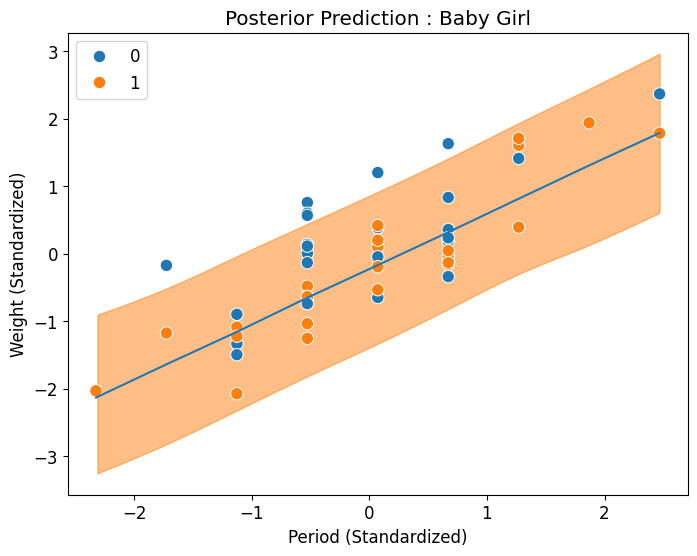

In [31]:
# 事後予測分布の表示
az.plot_hdi(x_scaled_new, obs_pred)
plt.plot(x_scaled_new, obs_mean)

# 観測データの表示
sns.scatterplot(x=x_scaled, y=y_scaled, hue=gender, s=80)

plt.xlabel('Period (Standardized)')
plt.ylabel('Weight (Standardized)')
plt.title('Posterior Prediction : Baby Girl');